In [1]:
import collections
import functools
import statistics
from typing import Callable, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
 * [Substep: EDA](#Substep:-EDA)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-7)
- [Step 8](#Step-8)
- [Step 9](#Step-9)
- [Step 10](#Step-10)

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
# disclaimer: may not work as is in Windows OS
# dataset source: https://grouplens.org/datasets/movielens/
!wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

--2022-03-29 22:45:30--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   315KB/s    in 3.0s    

2022-03-29 22:45:33 (315 KB/s) - ‘data/ml-latest-small.zip’ saved [978202/978202]



In [4]:
# disclaimer: may not work as is in Windows OS
# if `unzip` does not exist in your system: apt-get install unzip
!unzip -o data/ml-latest-small.zip -d data/

Archive:  data/ml-latest-small.zip
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  


## Step 1

The prediction $r_{ui}$ is set as:

$$ r_{ui} = \mu + b_u + b_i + q_{i}^T p_u$$

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. 

The same applies for item $i$ with $b_i$ and $q_i$.

To estimate all the unknown, we minimize the following regularized squared error:

$$ \sum_{r_{ui} \in R_{train}} (r_{ui} - \hat{r_{ui}})^2 + \lambda (b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2)$$

The minimization is performed by a stochastic gradient descent:

$$ b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$ b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$
$$ p_u \leftarrow p_u + \gamma (e_{ui} q_i - \lambda p_u)$$
$$ q_i \leftarrow q_i + \gamma (e_{ui} p_u - \lambda q_i)$$

where: $e_{ui} = r_{ui} - \hat{r_{ui}}$, $\gamma$ is the learning rate and $\lambda$ the regularization term. These steps are performed over all the ratings of the trainset and repeated $n$ times, where $n$ is the number of epochs.

Baselines are initialized to zero. User and item factors are randomly initialized according to a normal distribution.

[reference](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

## Step 2 + Step 3

In [5]:
reader = Reader(
    line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5)
)

In [6]:
data = Dataset.load_from_file("data/ml-latest-small/ratings.csv", reader=reader)

#### Substep: EDA

In [7]:
movielens = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    names=["user", "item", "rating", "timestamp"],
    skiprows=1,
)

inspect_df(movielens)

shape: (100836, 4)


,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
movielens[movielens["rating"].isin([0.5, 1.5, 2.5, 3.5, 4.5])]

,user,item,rating,timestamp
234,2,1704,4.5,1445715228
237,2,8798,3.5,1445714960
240,2,58559,4.5,1445715141
242,2,68157,4.5,1445715154
247,2,80489,4.5,1445715340
...,...,...,...,...
100820,610,160341,2.5,1479545749
100821,610,160527,4.5,1479544998
100826,610,162350,3.5,1493849971
100827,610,163937,3.5,1493848789


In [9]:
print(f"number of users: {len(movielens['user'].unique())}")

number of users: 610


In [10]:
print(f"number of items: {len(movielens['item'].unique())}")

number of items: 9724


In [11]:
movielens["created_at"] = pd.to_datetime(movielens["timestamp"], unit="s")
movielens["created_at"] = pd.to_datetime(movielens["created_at"], format="%Y-%m")

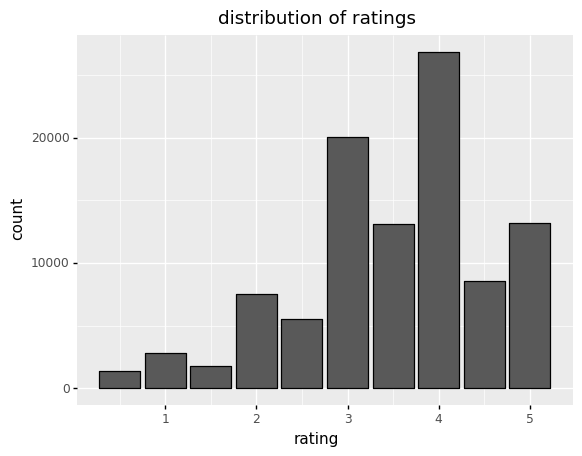

<ggplot: (8773687233172)>

In [12]:
(
    ggplot(movielens, aes(x="rating"))
    + geom_bar(color="black")
    + labs(x="rating", title="distribution of ratings")
)

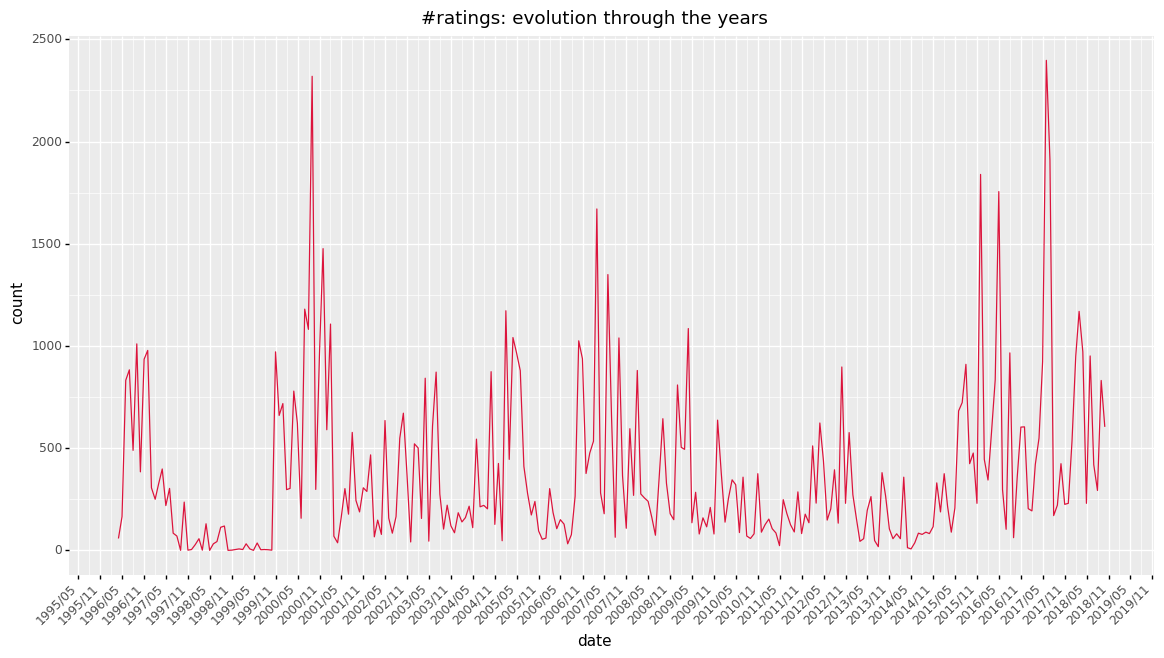

<ggplot: (8773566562467)>

In [13]:
(
    ggplot(
        movielens.groupby(pd.Grouper(key="created_at", freq="M")).count().reset_index()
    )
    + geom_line(aes(x="created_at", y="item"), color="crimson")
    + labs(x="date", y="count", title="#ratings: evolution through the years")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

## Step 4

In [14]:
recsys_small = SVD(
    n_factors=4,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [15]:
recsys_large = SVD(
    n_factors=20,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [16]:
cv_results = {}

cv_results["SVD w/ 4 factors"] = cross_validate(
    recsys_small,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7580  0.7693  0.7609  0.7574  0.7652  0.7622  0.0045  
RMSE (testset)    0.8707  0.8771  0.8723  0.8703  0.8747  0.8730  0.0026  
MAE (testset)     0.6647  0.6702  0.6690  0.6644  0.6681  0.6673  0.0023  
MSE (trainset)    0.5122  0.5030  0.5075  0.5085  0.5037  0.5070  0.0034  
RMSE (trainset)   0.7157  0.7092  0.7124  0.7131  0.7097  0.7120  0.0024  
MAE (trainset)    0.5514  0.5458  0.5469  0.5488  0.5460  0.5478  0.0021  
Fit time          1.70    1.71    1.69    1.68    1.68    1.69    0.01    
Test time         0.09    0.09    0.09    0.10    0.10    0.09    0.00    


In [17]:
cv_results["SVD w/ 20 factors"] = cross_validate(
    recsys_large,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7823  0.7784  0.7886  0.7773  0.7846  0.7822  0.0041  
RMSE (testset)    0.8845  0.8823  0.8880  0.8817  0.8858  0.8844  0.0023  
MAE (testset)     0.6741  0.6735  0.6790  0.6763  0.6786  0.6763  0.0022  
MSE (trainset)    0.3015  0.3050  0.2999  0.3041  0.3005  0.3022  0.0020  
RMSE (trainset)   0.5491  0.5523  0.5476  0.5515  0.5482  0.5497  0.0018  
MAE (trainset)    0.4242  0.4262  0.4225  0.4257  0.4222  0.4241  0.0016  
Fit time          3.37    3.51    3.32    3.29    3.26    3.35    0.09    
Test time         0.11    0.10    0.12    0.10    0.11    0.11    0.01    


In [18]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE (train)"] = df["train_rmse"].map(lambda x: statistics.mean(x))
df["mean RMSE (test)"] = df["test_rmse"].map(lambda x: statistics.mean(x))

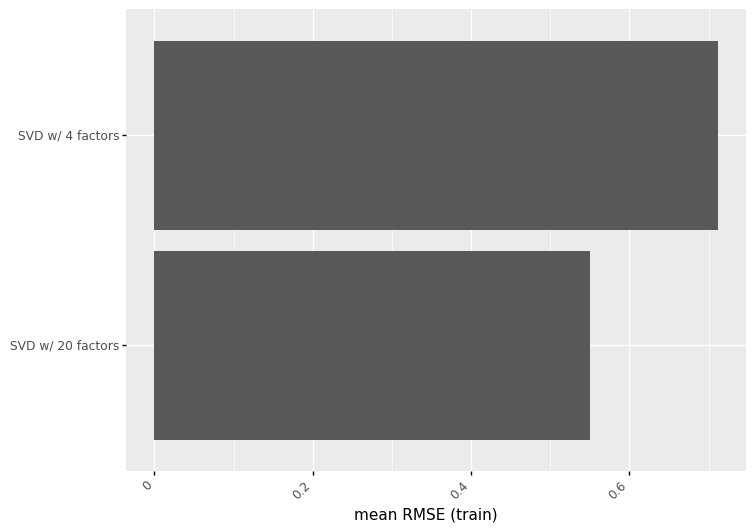

<ggplot: (8773566197998)>

In [19]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (train)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (train)")
    + coord_flip()
)

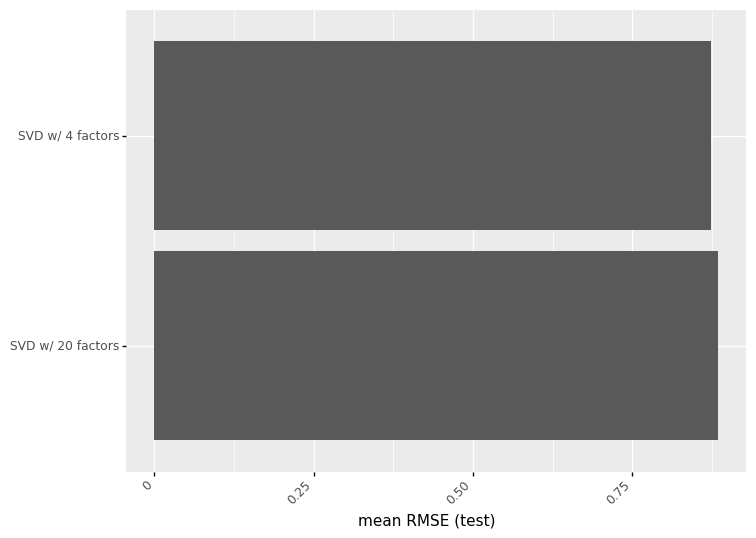

<ggplot: (8773678482682)>

In [20]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (test)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (test)")
    + coord_flip()
)

## Step 5

In [21]:
ratings = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    usecols=["user", "item", "rating"],
    names=["user", "item", "rating"],
    skiprows=1,
)

inspect_df(ratings)

shape: (100836, 3)


,user,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [22]:
ratings["user"] = ratings.groupby("user").ngroup()

In [23]:
ratings["item"] = ratings.groupby("item").ngroup()

In [24]:
def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:
    return collections.OrderedDict(
        x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [25]:
def create_tf_datasets(
    data: pd.DataFrame,
    transform_func: Callable,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_client: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["user"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    for _, user_ratings in data.groupby("user"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_client)
            .shuffle(buffer_size=max_items_per_client, seed=42)
            .batch(batch_size)
            .map(transform_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

In [26]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset]]:
    """Splits a list of user TF datasets into train/test by user."""
    np.random.seed(42)
    np.random.shuffle(tf_datasets)

    train_idx = int(len(tf_datasets) * train_fraction)

    # Note that the test data contains completely different users, not
    # just unseen ratings from train users.
    return (
        tf_datasets[:train_idx],
        tf_datasets[train_idx:],
    )

In [27]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [28]:
tf_trainsets, tf_testsets = split_tf_datasets(tf_datasets, train_fraction=0.8)

## Step 6

In [29]:
nest_asyncio.apply()

In [30]:
n_users = len(ratings["user"].unique())
n_items = len(ratings["item"].unique())

In [31]:
def matrix_factorization_model(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A federation-friendly Matrix Factorization model."""
    combined_input = tf.keras.layers.Input(
        shape=[2], dtype="int32", name="combined_input"
    )
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(combined_input[:, 0])
    u = tf.keras.layers.Flatten()(u)

    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(combined_input[:, 1])
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    model = tf.keras.Model(inputs=combined_input, outputs=output)

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 2], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [32]:
model_fn = functools.partial(
    matrix_factorization_model,
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=4,
)

In [33]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [34]:
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [35]:
state = iterative_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[ 0.01468258,  0.00567931,  0.00495758,  0.00324589],
       [ 0.03179849, -0.0492647 , -0.02005481, -0.04163704],
       [-0.03475098, -0.01713616,  0.01399508,  0.04243547],
       ...,
       [ 0.00862901,  0.00322223,  0.01444075,  0.04583659],
       [ 0.03038353,  0.02589783,  0.00930526,  0.02227395],
       [ 0.01414761, -0.00780897,  0.04580608,  0.02988801]],
      dtype=float32), array([[-0.02925836, -0.01624753,  0.03568989,  0.0261209 ],
       [ 0.01137955,  0.03505001, -0.00913109, -0.0486768 ],
       [ 0.02154956,  0.03719026, -0.04055684, -0.04193204],
       ...,
       [-0.04047085,  0.02363309,  0.01748785, -0.01520915],
       [-0.02010256,  0.00147226,  0.0054672 , -0.00792523],
       [ 0.03594568,  0.01957921,  0.04275305,  0.00249139]],
      dtype=float32)], non_trainable=[])


In [36]:
print("User variables shape:", state.model.trainable[1].shape)

User variables shape: (611, 4)


In [37]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9725, 4)


In [38]:
evaluation_computation = tff.learning.build_federated_evaluation(model_fn)

In [39]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,2],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [40]:
NUM_ROUNDS = 200  # we will set up a training loop to train over multiple rounds.

In [41]:
train_losses, train_accs = [], []

state = iterative_process.initialize()

for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('root_mean_squared_error', 3.6591628), ('loss', 13.389473), ('num_examples', 8644), ('num_batches', 888)])
Train round 1: OrderedDict([('root_mean_squared_error', 3.6203775), ('loss', 13.107134), ('num_examples', 8908), ('num_batches', 917)])
Train round 2: OrderedDict([('root_mean_squared_error', 3.6475613), ('loss', 13.304705), ('num_examples', 9100), ('num_batches', 932)])
Train round 3: OrderedDict([('root_mean_squared_error', 3.6928227), ('loss', 13.636939), ('num_examples', 7853), ('num_batches', 811)])
Train round 4: OrderedDict([('root_mean_squared_error', 3.6223826), ('loss', 13.121655), ('num_examples', 9232), ('num_batches', 947)])
Train round 5: OrderedDict([('root_mean_squared_error', 3.682296), ('loss', 13.559304), ('num_examples', 8628), ('num_batches', 887)])
Train round 6: OrderedDict([('root_mean_squared_error', 3.7147858), ('loss', 13.799635), ('num_examples', 9198), ('num_batches', 943)])
Train round 7: OrderedDict([('root_mean_squared_e

Train round 61: OrderedDict([('root_mean_squared_error', 3.762341), ('loss', 14.15521), ('num_examples', 8117), ('num_batches', 836)])
Train round 62: OrderedDict([('root_mean_squared_error', 3.7075777), ('loss', 13.746133), ('num_examples', 8083), ('num_batches', 831)])
Train round 63: OrderedDict([('root_mean_squared_error', 3.685967), ('loss', 13.586352), ('num_examples', 7246), ('num_batches', 750)])
Train round 64: OrderedDict([('root_mean_squared_error', 3.6558838), ('loss', 13.365486), ('num_examples', 9553), ('num_batches', 979)])
Train round 65: OrderedDict([('root_mean_squared_error', 3.6361732), ('loss', 13.221756), ('num_examples', 8580), ('num_batches', 883)])
Train round 66: OrderedDict([('root_mean_squared_error', 3.6869874), ('loss', 13.593877), ('num_examples', 7509), ('num_batches', 773)])
Train round 67: OrderedDict([('root_mean_squared_error', 3.6451082), ('loss', 13.286815), ('num_examples', 9124), ('num_batches', 933)])
Train round 68: OrderedDict([('root_mean_squ

Train round 121: OrderedDict([('root_mean_squared_error', 3.3955605), ('loss', 11.529832), ('num_examples', 7966), ('num_batches', 819)])
Train round 122: OrderedDict([('root_mean_squared_error', 3.4272811), ('loss', 11.746257), ('num_examples', 7438), ('num_batches', 768)])
Train round 123: OrderedDict([('root_mean_squared_error', 3.2188706), ('loss', 10.361129), ('num_examples', 8850), ('num_batches', 910)])
Train round 124: OrderedDict([('root_mean_squared_error', 3.2137053), ('loss', 10.327903), ('num_examples', 9814), ('num_batches', 1005)])
Train round 125: OrderedDict([('root_mean_squared_error', 3.4567873), ('loss', 11.94938), ('num_examples', 8583), ('num_batches', 882)])
Train round 126: OrderedDict([('root_mean_squared_error', 3.1835425), ('loss', 10.134944), ('num_examples', 9440), ('num_batches', 967)])
Train round 127: OrderedDict([('root_mean_squared_error', 3.548442), ('loss', 12.59144), ('num_examples', 7796), ('num_batches', 805)])
Train round 128: OrderedDict([('root

2022-03-29 22:51:44.461731: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 142: OrderedDict([('root_mean_squared_error', 3.2199574), ('loss', 10.368126), ('num_examples', 7594), ('num_batches', 783)])
Train round 143: OrderedDict([('root_mean_squared_error', 3.2875922), ('loss', 10.808262), ('num_examples', 7867), ('num_batches', 812)])
Train round 144: OrderedDict([('root_mean_squared_error', 3.2483127), ('loss', 10.551537), ('num_examples', 6985), ('num_batches', 722)])
Train round 145: OrderedDict([('root_mean_squared_error', 3.1832283), ('loss', 10.132943), ('num_examples', 9292), ('num_batches', 952)])


2022-03-29 22:51:54.985730: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 146: OrderedDict([('root_mean_squared_error', 3.0594504), ('loss', 9.360237), ('num_examples', 8417), ('num_batches', 863)])
Train round 147: OrderedDict([('root_mean_squared_error', 2.9767308), ('loss', 8.860927), ('num_examples', 9616), ('num_batches', 986)])
Train round 148: OrderedDict([('root_mean_squared_error', 3.1844366), ('loss', 10.140637), ('num_examples', 6920), ('num_batches', 716)])
Train round 149: OrderedDict([('root_mean_squared_error', 2.9482503), ('loss', 8.69218), ('num_examples', 9125), ('num_batches', 937)])
Train round 150: OrderedDict([('root_mean_squared_error', 3.3859828), ('loss', 11.46488), ('num_examples', 6930), ('num_batches', 717)])
Train round 151: OrderedDict([('root_mean_squared_error', 3.1647265), ('loss', 10.015494), ('num_examples', 8848), ('num_batches', 908)])
Train round 152: OrderedDict([('root_mean_squared_error', 3.1561167), ('loss', 9.961073), ('num_examples', 8204), ('num_batches', 842)])
Train round 153: OrderedDict([('root_mea

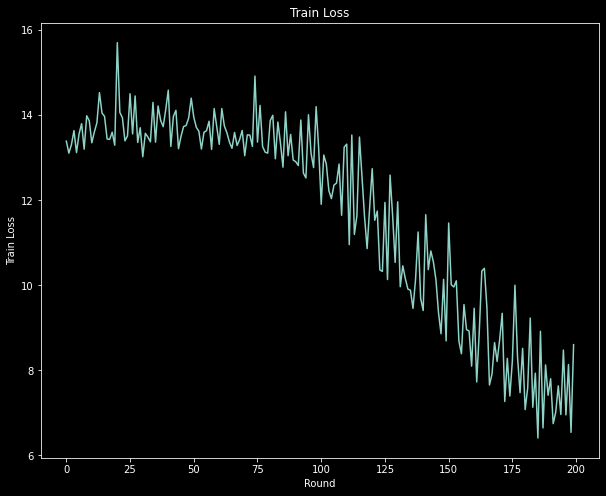

In [42]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

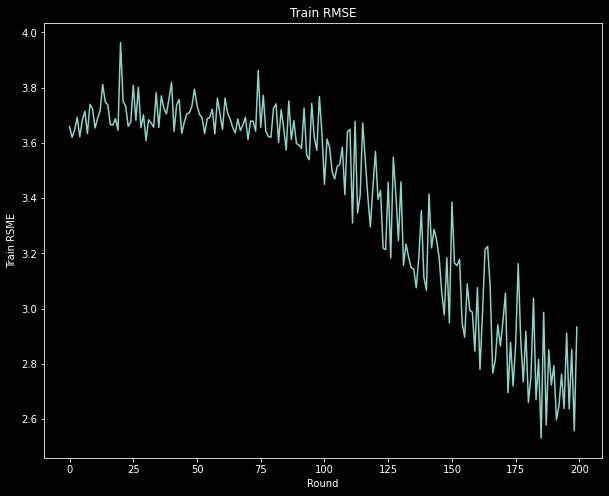

In [43]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [44]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("RMSE on Test Set:", eval_metrics["eval"]["root_mean_squared_error"])

2022-03-29 22:54:11.661978: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


RMSE on Test Set: 3.7825847


## Step 7

In [52]:
model_fn = functools.partial(
    matrix_factorization_model,
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=4,
)

In [53]:
fedprox_learning_process = tff.learning.algorithms.build_unweighted_fed_prox(
    model_fn,
    proximal_strength=10e-4,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
)

In [54]:
print(fedprox_learning_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    <>,
    <>
  >,
  finalizer=<
    int64
  >
>@SERVER)


In [55]:
evaluation_computation = tff.learning.build_federated_evaluation(
    model_fn,
)

In [56]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,2],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [57]:
train_losses, train_rmses = [], []

state = fedprox_learning_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):

    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state = fedprox_learning_process.next(
        state if i == 0 else state.state, federated_train_data
    )

    train_loss = state.metrics["client_work"]["train"]["loss"]
    train_rmse = state.metrics["client_work"]["train"]["root_mean_squared_error"]

    print(f"Round {i} | train loss: {train_loss} | train RMSE: {train_rmse}")
    train_losses.append(train_loss)
    train_rmses.append(train_rmse)

Round 0 | train loss: 14.445063591003418 | train RMSE: 3.800666093826294
Round 1 | train loss: 12.863300323486328 | train RMSE: 3.5865442752838135
Round 2 | train loss: 12.981673240661621 | train RMSE: 3.603008985519409
Round 3 | train loss: 14.06955337524414 | train RMSE: 3.7509403228759766
Round 4 | train loss: 11.10766315460205 | train RMSE: 3.3328161239624023
Round 5 | train loss: 6.883570671081543 | train RMSE: 2.6236557960510254
Round 6 | train loss: 5.4634175300598145 | train RMSE: 2.337395429611206
Round 7 | train loss: 4.481811046600342 | train RMSE: 2.1170287132263184
Round 8 | train loss: 4.603305816650391 | train RMSE: 2.14553165435791
Round 9 | train loss: 4.599572658538818 | train RMSE: 2.1446614265441895
Round 10 | train loss: 3.901719093322754 | train RMSE: 1.9752769470214844
Round 11 | train loss: 3.5184707641601562 | train RMSE: 1.8757586479187012
Round 12 | train loss: 2.954676389694214 | train RMSE: 1.7189173698425293
Round 13 | train loss: 2.610311508178711 | train

Round 110 | train loss: 0.3956719934940338 | train RMSE: 0.6290246248245239
Round 111 | train loss: 0.40241721272468567 | train RMSE: 0.63436359167099
Round 112 | train loss: 0.4614361822605133 | train RMSE: 0.6792909502983093
Round 113 | train loss: 0.4122992753982544 | train RMSE: 0.6421053409576416
Round 114 | train loss: 0.39232948422431946 | train RMSE: 0.6263620853424072
Round 115 | train loss: 0.42629292607307434 | train RMSE: 0.6529111266136169
Round 116 | train loss: 0.38912293314933777 | train RMSE: 0.6237971186637878
Round 117 | train loss: 0.38028720021247864 | train RMSE: 0.6166743040084839
Round 118 | train loss: 0.4149329662322998 | train RMSE: 0.6441528797149658
Round 119 | train loss: 0.44785764813423157 | train RMSE: 0.6692216396331787
Round 120 | train loss: 0.487199991941452 | train RMSE: 0.6979970932006836
Round 121 | train loss: 0.3961804509162903 | train RMSE: 0.6294286847114563
Round 122 | train loss: 0.4422721564769745 | train RMSE: 0.6650354266166687
Round 123

2022-03-29 23:02:18.229724: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Round 158 | train loss: 0.40516671538352966 | train RMSE: 0.6365270614624023
Round 159 | train loss: 0.35933825373649597 | train RMSE: 0.5994483232498169
Round 160 | train loss: 0.2873004972934723 | train RMSE: 0.5360041856765747
Round 161 | train loss: 0.35588911175727844 | train RMSE: 0.5965644121170044
Round 162 | train loss: 0.37288394570350647 | train RMSE: 0.6106422543525696
Round 163 | train loss: 0.35760197043418884 | train RMSE: 0.597998321056366
Round 164 | train loss: 0.32704833149909973 | train RMSE: 0.5718814134597778
Round 165 | train loss: 0.31858476996421814 | train RMSE: 0.5644331574440002
Round 166 | train loss: 0.2841043174266815 | train RMSE: 0.5330143570899963
Round 167 | train loss: 0.30964675545692444 | train RMSE: 0.5564591288566589
Round 168 | train loss: 0.36923450231552124 | train RMSE: 0.6076467037200928
Round 169 | train loss: 0.36678096652030945 | train RMSE: 0.6056244373321533
Round 170 | train loss: 0.3755810260772705 | train RMSE: 0.6128466129302979
Rou

In [58]:
model_final_weights = state.state.global_model_weights

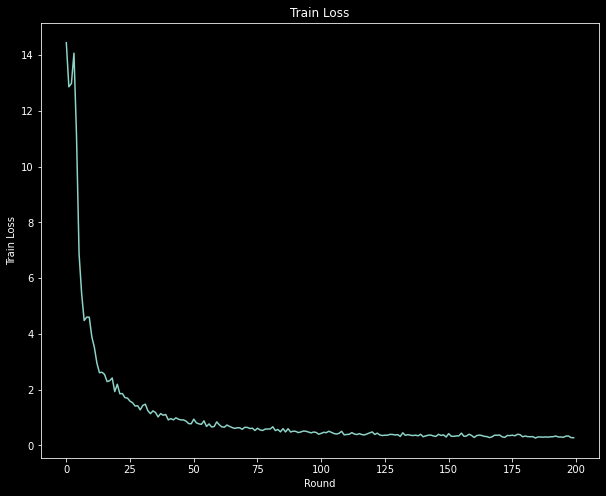

In [59]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

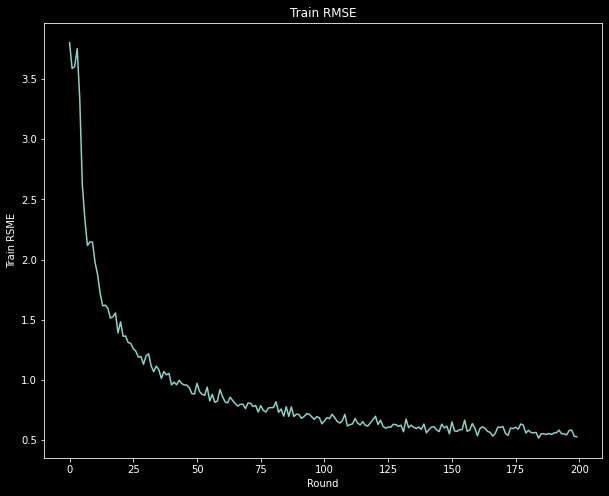

In [60]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [61]:
eval_metrics = evaluation_computation(model_final_weights, tf_testsets)
print("RMSE on Test Set:", eval_metrics["eval"]["root_mean_squared_error"])

RMSE on Test Set: 3.7838557


## Step 8

In [62]:
def transform_batch_for_fed_recon(batch: tf.Tensor) -> collections.OrderedDict:
    """we do not need the user since each client will only look at their own data."""
    return collections.OrderedDict(
        x=tf.cast(batch[:, 1:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [63]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch_for_fed_recon,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [64]:
tf_trainsets, tf_testsets = split_tf_datasets(
    tf_datasets,
    train_fraction=0.8,
)

In [65]:
class UserEmbedding(tf.keras.layers.Layer):
    """Keras layer representing an embedding for a single user."""

    def __init__(self, num_latent_factors, **kwargs):
        super().__init__(**kwargs)
        self.num_latent_factors = num_latent_factors

    def build(self, input_shape):
        self.embedding = self.add_weight(
            shape=(1, self.num_latent_factors),
            initializer="uniform",
            dtype=tf.float32,
            name="UserEmbeddingKernel",
        )
        super().build(input_shape)

    def call(self, inputs):
        return self.embedding

    def compute_output_shape(self):
        return (1, self.num_latent_factors)

In [66]:
def get_matrix_factorization_reconstruction_model(
    n_items: int, n_latent_factors: int
) -> tff.learning.reconstruction.Model:
    """Defines a Keras matrix factorization model."""
    # layers with variables will be partitioned into global and local layers.
    global_layers = []
    local_layers = []

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    global_layers.append(item_embedding_layer)
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")
    local_layers.append(user_embedding_layer)

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.reconstruction.from_keras_model(
        keras_model=model,
        global_layers=global_layers,
        local_layers=local_layers,
        input_spec=input_spec,
    )

In [67]:
model_fn = functools.partial(
    get_matrix_factorization_reconstruction_model, n_items=n_items, n_latent_factors=4
)

In [68]:
class RatingAccuracy(tf.keras.metrics.Mean):
    """Keras metric computing accuracy of reconstructed ratings."""

    def __init__(self, name: str = "rating_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)

    def update_state(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None,
    ):
        absolute_diffs = tf.abs(y_true - y_pred)
        # A [batch_size, 1] tf.bool tensor indicating correctness within the
        # threshold for each example in a batch. A 0.5 threshold corresponds
        # to correctness when predictions are rounded to the nearest whole
        # number.
        example_accuracies = tf.less_equal(absolute_diffs, 0.5)
        super().update_state(example_accuracies, sample_weight=sample_weight)

In [69]:
loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy(), tf.keras.metrics.RootMeanSquaredError()]

In [70]:
training_process = tff.learning.reconstruction.build_training_process(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.1),
)

In [71]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [72]:
evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(tf.keras.optimizers.SGD, 0.1),
)

In [73]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,1],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  broadcast=<>,
  eval=<
    loss=float32,
    rating_accuracy=float32,
    root_mean_squared_error=float32
  >
>@SERVER)


In [74]:
state = training_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[ 0.032397  ,  0.00683475, -0.03634749,  0.01848885],
       [-0.0056657 , -0.01406003, -0.03018404,  0.03773868],
       [-0.03315934, -0.01758755,  0.0484832 , -0.04275289],
       ...,
       [ 0.00108583,  0.03362406, -0.01576094,  0.04999611],
       [ 0.00850909, -0.00396698,  0.04703293, -0.02560939],
       [ 0.03974214,  0.02007693,  0.04207966, -0.02986131]],
      dtype=float32)], non_trainable=[])


In [75]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9724, 4)


In [76]:
train_losses, train_accs, train_rmses = [], [], []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = training_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["rating_accuracy"])
    train_rmses.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('rating_accuracy', 0.0037977688), ('root_mean_squared_error', 3.6690292), ('loss', 13.461775)])
Train round 1: OrderedDict([('rating_accuracy', 0.0034514496), ('root_mean_squared_error', 3.608174), ('loss', 13.01892)])
Train round 2: OrderedDict([('rating_accuracy', 0.008320216), ('root_mean_squared_error', 3.6286469), ('loss', 13.167078)])
Train round 3: OrderedDict([('rating_accuracy', 0.003153745), ('root_mean_squared_error', 3.684771), ('loss', 13.577538)])
Train round 4: OrderedDict([('rating_accuracy', 0.006672598), ('root_mean_squared_error', 3.5905397), ('loss', 12.891975)])


2022-03-29 23:06:17.278523: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 5: OrderedDict([('rating_accuracy', 0.00831749), ('root_mean_squared_error', 3.545916), ('loss', 12.573521)])
Train round 6: OrderedDict([('rating_accuracy', 0.015844677), ('root_mean_squared_error', 3.360343), ('loss', 11.291905)])
Train round 7: OrderedDict([('rating_accuracy', 0.070332184), ('root_mean_squared_error', 2.9890742), ('loss', 8.934566)])
Train round 8: OrderedDict([('rating_accuracy', 0.054640718), ('root_mean_squared_error', 2.895365), ('loss', 8.383139)])
Train round 9: OrderedDict([('rating_accuracy', 0.11322484), ('root_mean_squared_error', 2.6239276), ('loss', 6.884996)])
Train round 10: OrderedDict([('rating_accuracy', 0.09685506), ('root_mean_squared_error', 2.5549), ('loss', 6.5275145)])
Train round 11: OrderedDict([('rating_accuracy', 0.15380986), ('root_mean_squared_error', 2.3354461), ('loss', 5.4543095)])
Train round 12: OrderedDict([('rating_accuracy', 0.12344041), ('root_mean_squared_error', 2.4590793), ('loss', 6.047071)])
Train round 13: Orde

2022-03-29 23:07:14.985714: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 26: OrderedDict([('rating_accuracy', 0.23715188), ('root_mean_squared_error', 1.8264917), ('loss', 3.336072)])


2022-03-29 23:07:17.154150: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 27: OrderedDict([('rating_accuracy', 0.20981337), ('root_mean_squared_error', 1.9048679), ('loss', 3.6285217)])
Train round 28: OrderedDict([('rating_accuracy', 0.26602563), ('root_mean_squared_error', 1.6554478), ('loss', 2.7405076)])
Train round 29: OrderedDict([('rating_accuracy', 0.24943253), ('root_mean_squared_error', 1.6764331), ('loss', 2.8104281)])
Train round 30: OrderedDict([('rating_accuracy', 0.27859026), ('root_mean_squared_error', 1.6288921), ('loss', 2.6532893)])
Train round 31: OrderedDict([('rating_accuracy', 0.28637582), ('root_mean_squared_error', 1.631946), ('loss', 2.6632478)])
Train round 32: OrderedDict([('rating_accuracy', 0.30057928), ('root_mean_squared_error', 1.5276153), ('loss', 2.3336084)])
Train round 33: OrderedDict([('rating_accuracy', 0.26235527), ('root_mean_squared_error', 1.6665064), ('loss', 2.7772434)])
Train round 34: OrderedDict([('rating_accuracy', 0.24170868), ('root_mean_squared_error', 1.6950136), ('loss', 2.8730712)])
Train rou

2022-03-29 23:07:51.049702: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 39: OrderedDict([('rating_accuracy', 0.23006135), ('root_mean_squared_error', 1.7036579), ('loss', 2.90245)])
Train round 40: OrderedDict([('rating_accuracy', 0.31336927), ('root_mean_squared_error', 1.6111524), ('loss', 2.5958123)])
Train round 41: OrderedDict([('rating_accuracy', 0.34195888), ('root_mean_squared_error', 1.5037882), ('loss', 2.261379)])
Train round 42: OrderedDict([('rating_accuracy', 0.29692647), ('root_mean_squared_error', 1.5507448), ('loss', 2.4048095)])
Train round 43: OrderedDict([('rating_accuracy', 0.3442198), ('root_mean_squared_error', 1.5192074), ('loss', 2.307991)])
Train round 44: OrderedDict([('rating_accuracy', 0.35087353), ('root_mean_squared_error', 1.4029318), ('loss', 1.9682178)])
Train round 45: OrderedDict([('rating_accuracy', 0.2826765), ('root_mean_squared_error', 1.5821984), ('loss', 2.503352)])
Train round 46: OrderedDict([('rating_accuracy', 0.3113358), ('root_mean_squared_error', 1.5610486), ('loss', 2.436873)])


2022-03-29 23:08:12.204235: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 47: OrderedDict([('rating_accuracy', 0.35898674), ('root_mean_squared_error', 1.4609743), ('loss', 2.1344461)])
Train round 48: OrderedDict([('rating_accuracy', 0.25603864), ('root_mean_squared_error', 1.5929017), ('loss', 2.5373359)])


2022-03-29 23:08:18.421781: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 49: OrderedDict([('rating_accuracy', 0.2578173), ('root_mean_squared_error', 1.6124587), ('loss', 2.600023)])
Train round 50: OrderedDict([('rating_accuracy', 0.34799513), ('root_mean_squared_error', 1.4185333), ('loss', 2.0122368)])
Train round 51: OrderedDict([('rating_accuracy', 0.3699379), ('root_mean_squared_error', 1.3987942), ('loss', 1.9566255)])
Train round 52: OrderedDict([('rating_accuracy', 0.3134978), ('root_mean_squared_error', 1.4356194), ('loss', 2.061003)])
Train round 53: OrderedDict([('rating_accuracy', 0.3841723), ('root_mean_squared_error', 1.3653293), ('loss', 1.8641241)])


2022-03-29 23:08:32.777431: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 54: OrderedDict([('rating_accuracy', 0.29124627), ('root_mean_squared_error', 1.481534), ('loss', 2.1949432)])


2022-03-29 23:08:35.323712: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 55: OrderedDict([('rating_accuracy', 0.37853366), ('root_mean_squared_error', 1.3982567), ('loss', 1.9551219)])
Train round 56: OrderedDict([('rating_accuracy', 0.35506374), ('root_mean_squared_error', 1.4102874), ('loss', 1.9889106)])
Train round 57: OrderedDict([('rating_accuracy', 0.38226902), ('root_mean_squared_error', 1.3506715), ('loss', 1.8243136)])
Train round 58: OrderedDict([('rating_accuracy', 0.28063118), ('root_mean_squared_error', 1.572263), ('loss', 2.472011)])
Train round 59: OrderedDict([('rating_accuracy', 0.34593326), ('root_mean_squared_error', 1.3872275), ('loss', 1.9244004)])
Train round 60: OrderedDict([('rating_accuracy', 0.33611444), ('root_mean_squared_error', 1.3852856), ('loss', 1.9190162)])
Train round 61: OrderedDict([('rating_accuracy', 0.3674089), ('root_mean_squared_error', 1.3937169), ('loss', 1.942447)])


2022-03-29 23:08:55.508347: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-29 23:08:55.562285: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 62: OrderedDict([('rating_accuracy', 0.32542717), ('root_mean_squared_error', 1.4053484), ('loss', 1.9750043)])
Train round 63: OrderedDict([('rating_accuracy', 0.3148413), ('root_mean_squared_error', 1.4788363), ('loss', 2.186957)])
Train round 64: OrderedDict([('rating_accuracy', 0.3816156), ('root_mean_squared_error', 1.2848895), ('loss', 1.6509409)])
Train round 65: OrderedDict([('rating_accuracy', 0.38803828), ('root_mean_squared_error', 1.3527839), ('loss', 1.8300245)])
Train round 66: OrderedDict([('rating_accuracy', 0.34607977), ('root_mean_squared_error', 1.4514132), ('loss', 2.1066003)])
Train round 67: OrderedDict([('rating_accuracy', 0.3900293), ('root_mean_squared_error', 1.2631702), ('loss', 1.5955992)])
Train round 68: OrderedDict([('rating_accuracy', 0.33315912), ('root_mean_squared_error', 1.3628981), ('loss', 1.8574913)])


2022-03-29 23:09:14.121058: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 69: OrderedDict([('rating_accuracy', 0.40298164), ('root_mean_squared_error', 1.2765367), ('loss', 1.629546)])
Train round 70: OrderedDict([('rating_accuracy', 0.3806804), ('root_mean_squared_error', 1.2851179), ('loss', 1.6515282)])
Train round 71: OrderedDict([('rating_accuracy', 0.3663578), ('root_mean_squared_error', 1.3466508), ('loss', 1.8134685)])
Train round 72: OrderedDict([('rating_accuracy', 0.35744235), ('root_mean_squared_error', 1.3424605), ('loss', 1.8022003)])
Train round 73: OrderedDict([('rating_accuracy', 0.4217284), ('root_mean_squared_error', 1.2814304), ('loss', 1.642064)])
Train round 74: OrderedDict([('rating_accuracy', 0.3286052), ('root_mean_squared_error', 1.3965927), ('loss', 1.9504716)])
Train round 75: OrderedDict([('rating_accuracy', 0.39684626), ('root_mean_squared_error', 1.3088683), ('loss', 1.7131361)])
Train round 76: OrderedDict([('rating_accuracy', 0.36081654), ('root_mean_squared_error', 1.3016156), ('loss', 1.6942034)])
Train round 77

2022-03-29 23:09:43.119381: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 79: OrderedDict([('rating_accuracy', 0.41858408), ('root_mean_squared_error', 1.2274554), ('loss', 1.5066469)])
Train round 80: OrderedDict([('rating_accuracy', 0.34770358), ('root_mean_squared_error', 1.429111), ('loss', 2.0423584)])
Train round 81: OrderedDict([('rating_accuracy', 0.38451305), ('root_mean_squared_error', 1.3289323), ('loss', 1.766061)])
Train round 82: OrderedDict([('rating_accuracy', 0.4059925), ('root_mean_squared_error', 1.3027214), ('loss', 1.697083)])
Train round 83: OrderedDict([('rating_accuracy', 0.3865462), ('root_mean_squared_error', 1.2658734), ('loss', 1.6024356)])
Train round 84: OrderedDict([('rating_accuracy', 0.40122294), ('root_mean_squared_error', 1.2389178), ('loss', 1.5349176)])
Train round 85: OrderedDict([('rating_accuracy', 0.40939122), ('root_mean_squared_error', 1.2453008), ('loss', 1.550774)])
Train round 86: OrderedDict([('rating_accuracy', 0.34137237), ('root_mean_squared_error', 1.3506145), ('loss', 1.8241599)])


2022-03-29 23:10:06.197717: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 87: OrderedDict([('rating_accuracy', 0.4402771), ('root_mean_squared_error', 1.2304751), ('loss', 1.5140691)])
Train round 88: OrderedDict([('rating_accuracy', 0.44059515), ('root_mean_squared_error', 1.173345), ('loss', 1.3767384)])
Train round 89: OrderedDict([('rating_accuracy', 0.4418093), ('root_mean_squared_error', 1.2515676), ('loss', 1.5664214)])
Train round 90: OrderedDict([('rating_accuracy', 0.42451945), ('root_mean_squared_error', 1.2245748), ('loss', 1.4995836)])


2022-03-29 23:10:16.962321: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 91: OrderedDict([('rating_accuracy', 0.44187054), ('root_mean_squared_error', 1.2156322), ('loss', 1.4777617)])
Train round 92: OrderedDict([('rating_accuracy', 0.33354715), ('root_mean_squared_error', 1.4406828), ('loss', 2.0755668)])
Train round 93: OrderedDict([('rating_accuracy', 0.43742824), ('root_mean_squared_error', 1.2246498), ('loss', 1.4997671)])


2022-03-29 23:10:24.943281: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 94: OrderedDict([('rating_accuracy', 0.4209108), ('root_mean_squared_error', 1.29187), ('loss', 1.6689279)])
Train round 95: OrderedDict([('rating_accuracy', 0.3871437), ('root_mean_squared_error', 1.3469673), ('loss', 1.814321)])


2022-03-29 23:10:30.357720: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 96: OrderedDict([('rating_accuracy', 0.43012422), ('root_mean_squared_error', 1.2150958), ('loss', 1.4764576)])
Train round 97: OrderedDict([('rating_accuracy', 0.45063516), ('root_mean_squared_error', 1.18161), ('loss', 1.3962023)])
Train round 98: OrderedDict([('rating_accuracy', 0.4234536), ('root_mean_squared_error', 1.2324942), ('loss', 1.5190421)])
Train round 99: OrderedDict([('rating_accuracy', 0.39254197), ('root_mean_squared_error', 1.3078433), ('loss', 1.7104542)])
Train round 100: OrderedDict([('rating_accuracy', 0.46029514), ('root_mean_squared_error', 1.1555456), ('loss', 1.3352855)])
Train round 101: OrderedDict([('rating_accuracy', 0.4265648), ('root_mean_squared_error', 1.217281), ('loss', 1.4817729)])
Train round 102: OrderedDict([('rating_accuracy', 0.3918099), ('root_mean_squared_error', 1.2269413), ('loss', 1.505385)])
Train round 103: OrderedDict([('rating_accuracy', 0.43582705), ('root_mean_squared_error', 1.1644258), ('loss', 1.3558875)])


2022-03-29 23:10:53.358228: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 104: OrderedDict([('rating_accuracy', 0.45806453), ('root_mean_squared_error', 1.1437256), ('loss', 1.3081083)])
Train round 105: OrderedDict([('rating_accuracy', 0.43430078), ('root_mean_squared_error', 1.2195084), ('loss', 1.4872009)])
Train round 106: OrderedDict([('rating_accuracy', 0.44943053), ('root_mean_squared_error', 1.1717879), ('loss', 1.3730867)])


2022-03-29 23:11:01.846816: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 107: OrderedDict([('rating_accuracy', 0.39371577), ('root_mean_squared_error', 1.1928055), ('loss', 1.4227852)])
Train round 108: OrderedDict([('rating_accuracy', 0.4440542), ('root_mean_squared_error', 1.2111769), ('loss', 1.4669495)])
Train round 109: OrderedDict([('rating_accuracy', 0.410795), ('root_mean_squared_error', 1.227109), ('loss', 1.5057966)])
Train round 110: OrderedDict([('rating_accuracy', 0.37928978), ('root_mean_squared_error', 1.3034933), ('loss', 1.6990948)])
Train round 111: OrderedDict([('rating_accuracy', 0.43804663), ('root_mean_squared_error', 1.164507), ('loss', 1.3560765)])
Train round 112: OrderedDict([('rating_accuracy', 0.3075284), ('root_mean_squared_error', 1.4323655), ('loss', 2.051671)])
Train round 113: OrderedDict([('rating_accuracy', 0.44213718), ('root_mean_squared_error', 1.1639066), ('loss', 1.3546786)])
Train round 114: OrderedDict([('rating_accuracy', 0.47161573), ('root_mean_squared_error', 1.0956346), ('loss', 1.2004153)])
Train r

2022-03-29 23:11:29.153787: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 117: OrderedDict([('rating_accuracy', 0.43469894), ('root_mean_squared_error', 1.1873184), ('loss', 1.4097251)])
Train round 118: OrderedDict([('rating_accuracy', 0.4473189), ('root_mean_squared_error', 1.1045893), ('loss', 1.2201178)])
Train round 119: OrderedDict([('rating_accuracy', 0.3968254), ('root_mean_squared_error', 1.2140071), ('loss', 1.4738133)])


2022-03-29 23:11:38.065689: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 120: OrderedDict([('rating_accuracy', 0.3917749), ('root_mean_squared_error', 1.2840548), ('loss', 1.6487966)])


2022-03-29 23:11:40.962057: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 121: OrderedDict([('rating_accuracy', 0.4125387), ('root_mean_squared_error', 1.1997086), ('loss', 1.4393008)])
Train round 122: OrderedDict([('rating_accuracy', 0.42095026), ('root_mean_squared_error', 1.2284247), ('loss', 1.5090271)])


2022-03-29 23:11:45.385404: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 123: OrderedDict([('rating_accuracy', 0.4654933), ('root_mean_squared_error', 1.1092916), ('loss', 1.2305279)])


2022-03-29 23:11:48.569719: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 124: OrderedDict([('rating_accuracy', 0.48622128), ('root_mean_squared_error', 1.0407519), ('loss', 1.0831647)])
Train round 125: OrderedDict([('rating_accuracy', 0.45740342), ('root_mean_squared_error', 1.1188623), ('loss', 1.251853)])
Train round 126: OrderedDict([('rating_accuracy', 0.4736614), ('root_mean_squared_error', 1.0665087), ('loss', 1.1374408)])


2022-03-29 23:11:57.907851: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 127: OrderedDict([('rating_accuracy', 0.41646808), ('root_mean_squared_error', 1.1793358), ('loss', 1.3908329)])
Train round 128: OrderedDict([('rating_accuracy', 0.44008484), ('root_mean_squared_error', 1.1717918), ('loss', 1.373096)])
Train round 129: OrderedDict([('rating_accuracy', 0.45750105), ('root_mean_squared_error', 1.0615158), ('loss', 1.1268158)])
Train round 130: OrderedDict([('rating_accuracy', 0.40549543), ('root_mean_squared_error', 1.192835), ('loss', 1.4228554)])
Train round 131: OrderedDict([('rating_accuracy', 0.49929106), ('root_mean_squared_error', 1.0363958), ('loss', 1.0741162)])
Train round 132: OrderedDict([('rating_accuracy', 0.45439777), ('root_mean_squared_error', 1.1099253), ('loss', 1.2319341)])
Train round 133: OrderedDict([('rating_accuracy', 0.48646343), ('root_mean_squared_error', 1.026906), ('loss', 1.0545361)])
Train round 134: OrderedDict([('rating_accuracy', 0.4844424), ('root_mean_squared_error', 1.0493115), ('loss', 1.1010548)])


2022-03-29 23:12:20.133795: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 135: OrderedDict([('rating_accuracy', 0.47992486), ('root_mean_squared_error', 1.0784314), ('loss', 1.1630142)])
Train round 136: OrderedDict([('rating_accuracy', 0.49049753), ('root_mean_squared_error', 1.103782), ('loss', 1.2183348)])
Train round 137: OrderedDict([('rating_accuracy', 0.48623446), ('root_mean_squared_error', 1.0563391), ('loss', 1.1158525)])
Train round 138: OrderedDict([('rating_accuracy', 0.42516732), ('root_mean_squared_error', 1.1845919), ('loss', 1.4032578)])
Train round 139: OrderedDict([('rating_accuracy', 0.48778194), ('root_mean_squared_error', 1.0749232), ('loss', 1.1554598)])
Train round 140: OrderedDict([('rating_accuracy', 0.5014597), ('root_mean_squared_error', 1.0772468), ('loss', 1.1604607)])
Train round 141: OrderedDict([('rating_accuracy', 0.46022066), ('root_mean_squared_error', 1.1944859), ('loss', 1.4267967)])
Train round 142: OrderedDict([('rating_accuracy', 0.4471611), ('root_mean_squared_error', 1.1429961), ('loss', 1.3064401)])
Tra

2022-03-29 23:13:57.519159: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 169: OrderedDict([('rating_accuracy', 0.48253378), ('root_mean_squared_error', 1.0472294), ('loss', 1.0966895)])
Train round 170: OrderedDict([('rating_accuracy', 0.47840938), ('root_mean_squared_error', 1.0741622), ('loss', 1.1538247)])


2022-03-29 23:14:03.244773: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 171: OrderedDict([('rating_accuracy', 0.4578644), ('root_mean_squared_error', 1.1023153), ('loss', 1.2150991)])
Train round 172: OrderedDict([('rating_accuracy', 0.4988759), ('root_mean_squared_error', 1.0235493), ('loss', 1.0476532)])
Train round 173: OrderedDict([('rating_accuracy', 0.4995336), ('root_mean_squared_error', 1.0532734), ('loss', 1.109385)])
Train round 174: OrderedDict([('rating_accuracy', 0.5188465), ('root_mean_squared_error', 1.0447065), ('loss', 1.0914116)])
Train round 175: OrderedDict([('rating_accuracy', 0.51865953), ('root_mean_squared_error', 1.0967755), ('loss', 1.2029164)])
Train round 176: OrderedDict([('rating_accuracy', 0.40532365), ('root_mean_squared_error', 1.151339), ('loss', 1.3255816)])


2022-03-29 23:14:20.689504: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 177: OrderedDict([('rating_accuracy', 0.45676392), ('root_mean_squared_error', 1.1125801), ('loss', 1.2378343)])


2022-03-29 23:14:22.126071: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 178: OrderedDict([('rating_accuracy', 0.4977778), ('root_mean_squared_error', 1.0680823), ('loss', 1.1408)])


2022-03-29 23:14:26.316976: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 179: OrderedDict([('rating_accuracy', 0.46382636), ('root_mean_squared_error', 1.1139178), ('loss', 1.2408129)])
Train round 180: OrderedDict([('rating_accuracy', 0.52126956), ('root_mean_squared_error', 1.0119665), ('loss', 1.0240762)])
Train round 181: OrderedDict([('rating_accuracy', 0.49744305), ('root_mean_squared_error', 1.0094811), ('loss', 1.019052)])


2022-03-29 23:14:36.570799: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 182: OrderedDict([('rating_accuracy', 0.44759652), ('root_mean_squared_error', 1.0885965), ('loss', 1.1850423)])
Train round 183: OrderedDict([('rating_accuracy', 0.53471553), ('root_mean_squared_error', 1.0553436), ('loss', 1.1137502)])
Train round 184: OrderedDict([('rating_accuracy', 0.5187139), ('root_mean_squared_error', 1.0608515), ('loss', 1.1254058)])
Train round 185: OrderedDict([('rating_accuracy', 0.5228547), ('root_mean_squared_error', 0.9993747), ('loss', 0.99874973)])
Train round 186: OrderedDict([('rating_accuracy', 0.46014994), ('root_mean_squared_error', 1.0849102), ('loss', 1.1770301)])
Train round 187: OrderedDict([('rating_accuracy', 0.5371047), ('root_mean_squared_error', 0.94648385), ('loss', 0.89583164)])
Train round 188: OrderedDict([('rating_accuracy', 0.4170076), ('root_mean_squared_error', 1.1426402), ('loss', 1.3056266)])


2022-03-29 23:14:57.643617: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 189: OrderedDict([('rating_accuracy', 0.49276486), ('root_mean_squared_error', 1.0643469), ('loss', 1.1328344)])
Train round 190: OrderedDict([('rating_accuracy', 0.47569528), ('root_mean_squared_error', 1.033097), ('loss', 1.0672896)])
Train round 191: OrderedDict([('rating_accuracy', 0.5228403), ('root_mean_squared_error', 1.0039006), ('loss', 1.0078166)])
Train round 192: OrderedDict([('rating_accuracy', 0.5161152), ('root_mean_squared_error', 1.0015631), ('loss', 1.0031286)])
Train round 193: OrderedDict([('rating_accuracy', 0.48848033), ('root_mean_squared_error', 1.0237516), ('loss', 1.0480673)])
Train round 194: OrderedDict([('rating_accuracy', 0.5494015), ('root_mean_squared_error', 0.93677104), ('loss', 0.87754005)])


2022-03-29 23:15:15.494616: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-29 23:15:15.621702: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 195: OrderedDict([('rating_accuracy', 0.45751446), ('root_mean_squared_error', 1.1158794), ('loss', 1.2451869)])
Train round 196: OrderedDict([('rating_accuracy', 0.52707183), ('root_mean_squared_error', 0.98150325), ('loss', 0.9633488)])


2022-03-29 23:15:21.369733: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 197: OrderedDict([('rating_accuracy', 0.44408476), ('root_mean_squared_error', 1.0732454), ('loss', 1.1518557)])
Train round 198: OrderedDict([('rating_accuracy', 0.53515095), ('root_mean_squared_error', 0.9740603), ('loss', 0.94879365)])
Train round 199: OrderedDict([('rating_accuracy', 0.41984963), ('root_mean_squared_error', 1.1337314), ('loss', 1.2853467)])


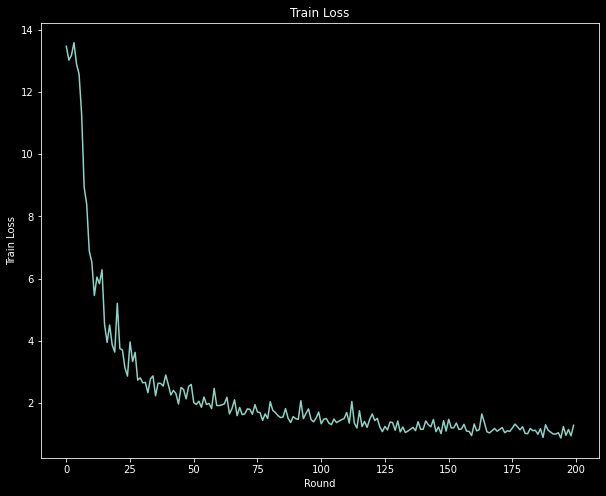

In [77]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

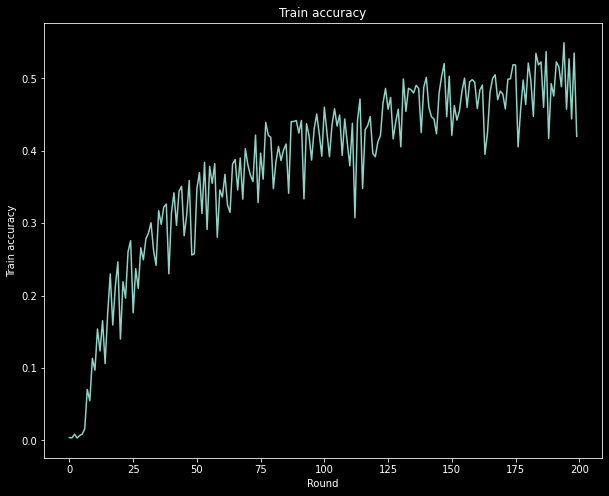

In [78]:
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train accuracy")
plt.xlabel("Round")
plt.title("Train accuracy")
plt.show()

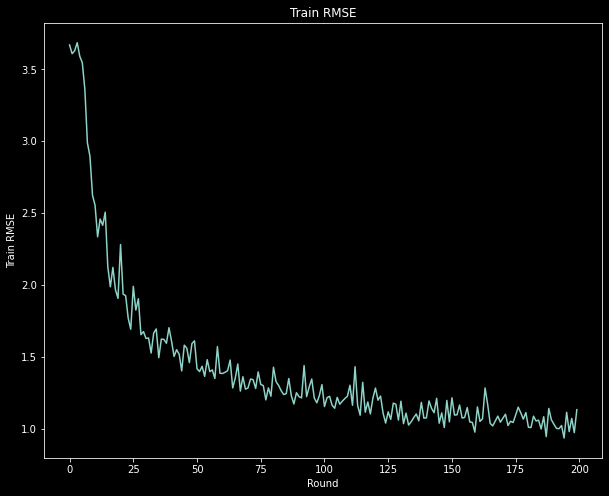

In [79]:
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RMSE")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [80]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("RMSE on Test Set:", eval_metrics["eval"]["root_mean_squared_error"])

RMSE on Test Set: 1.6366868


## Step 9

In [81]:
# already incorporated in previous steps

## Step 10

In [82]:
# report